# Introduction aux SVM

Le Support vector machines (SVM) est un algorithme supervisé pour la classification et la régression.

## 1. L'intuition

In [1]:
# import des librairies
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

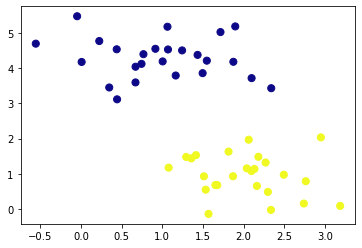

In [2]:
# simulation d'un jeu de données
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma');

Un classifieur linéaire essaierait de tracer une droite entre les 2 ensembles de données et, de cette manière créer un modèle de classification. Dans un cas en dimension 2, comme ici, on pourrait le faire directement *à la main*, seulement cela pose un problème : il y a plusieurs droites qui séparent parfaitement nos 2 ensembles de points...

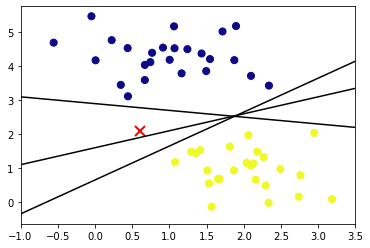

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Cela nous donne 3 séparateurs bien différents qui, néanmoins séparent parfaitement les 2 classes de cet échantillon. Selon quelle droite on choisit, un nouveau point (*celui marqué X par exemple*) ne sera pas assigné à la même classe. Il faut donc aller plus loin

## 2. Séparateurs à vastes marges

Pour pallier au problème évoqué précédemment, l'idée est la suivante : au lieu de tracer une droite "sans épaisseur", on va tracer autour de chaque droite une marge jusqu'aux points les plus proches. Cela donnerait ça.

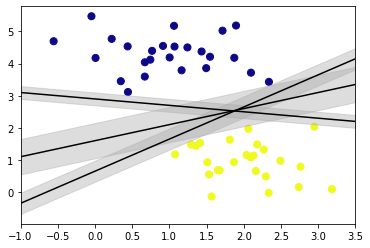

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

La droite qui maximise cette marge (ayant la marge la plus large) est celle qui sera choisie comme optimale par le modèle.

## 3. Ajuster un modèle Support Vector Machine

On va voir comment on fait ça avec sklearn. Pour le moment, on va utiliser le kernel linéaire et C très grand. On aura l'occasion de rediscuter de ces hyperparamètres.

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
svc = SVC(kernel='linear', C=1E10)
svc.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Pour mieux visualiser ce qu'il se passe, on peut créer une fonction qui affichera les frontières de décision et les zones qu'elles définissent.

In [6]:
def frontiere(model, ax=None, supp_vect=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # création d'une grille pour évaluer le modèle
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # afficher la frontière et les marges
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # afficher les vecteurs supports
    if supp_vect:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolor='black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

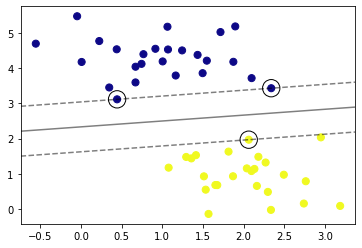

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma')
frontiere(svc);

Il s'agit donc de la droite qui maximise la marge entre les deux ensembles de points. On remarque que plusieurs points touchent la ligne (entourés en noir). Ces points sont des éléments important de ce modèle : ce sont les vecteurs supports qui donnent leur nom à l'algorithme. Dans sklearn, on peut les récupérer via l'attribut `support_vectors_`

In [8]:
svc.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Une des clés du succès de ce classifieur est que pour l'entraînement, seules les positions des vecteurs supports comptent. Tout point situé plus loin que la marge et qui sont du "bon côté" ne modifie pas l'ajustement. Techniquement, c'est dû au fait que ces points ne contribuent pas à la fonction de coût utilisée pour ajuster le modèle donc leur position et le nombre n'a pas d'importance tant qu'ils ne passent pas de l'autre côté de la marge.

On peut le voir en affichant par exemple la droite obtenue pour les 60 premiers points puis les 120 premiers points.

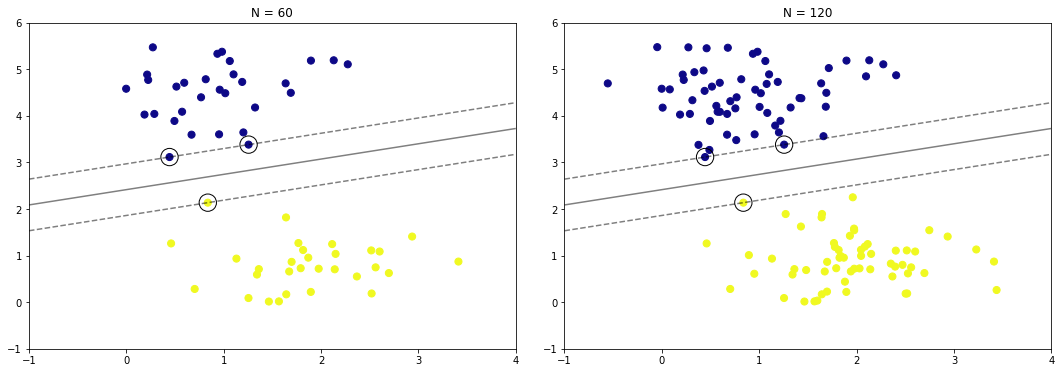

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,random_state=0, cluster_std=0.60)
    
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    frontiere(model, ax)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for ax, N in zip(axes, [60, 120]):
    plot_svm(N, ax)
    ax.set_title('N = {0}'.format(N))

Modèle et vecteurs supports obtenus pour 60 points à gauche et 120 points à droite. Deux fois plus de points mais les mêmes 3 vecteurs supports et donc le même modèle. Cette non-sensibilité aux points distants et une des grandes forces du modèle SVM.

In [10]:
from ipywidgets import interact, fixed #module pour ajouter des widgets interactives dans les notebooks
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

## 4. Au-delà des frontières linéaires : le kernel SVM

Là où ce modèle devient extrêmement utile et puissant, c'est lorsqu'on le combine avec les noyaux (kernels). On ne va pas s'étendre sur la théorie des noyaux qui va bien trop loin en mathématiques mais on peut retenir que les noyaux permettent de projeter nos données dans des espaces de plus grandes dimensions. Espaces dans lesquels le problème devient linéaire est peut donc être résolu par un classifieur linéaire avant de "rappatrier" la solution.

Regardons des données non linéairement séparées.

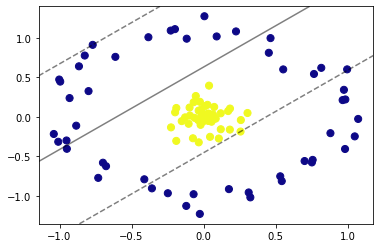

In [11]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma')
frontiere(clf, supp_vect=False);

Y un truc qui est sûr c'est qu'aucune discrimination linéaire ne pourra séparer correctement ces données. Par contre on peut projeter ces données dans un espace de plus grande dimension où le problème sera de nouveau linéaire. Par exemple, on pourrait utiliser une projection basé sur le rayon d'un cercle centré au milieu du nuage jaune.

In [27]:
r = np.exp(-(X ** 2).sum(axis=1))

On peut visualiser ces données dans un espace de dimension 3 où chaque point a pour coordonnées X1, X2 sur le plan et pour "altitude" la valeur du rayon r correspondant.

In [28]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='plasma')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=(-90, 90), azim=(-180, 180), X=fixed(X), y=fixed(y));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-90), IntSlider(value=30, descriptio…

Les données deviennent clairement linéairement séparables en tracant un plan à par exemple r=0.7

Ici nous avons choisi et ajusté la projection qui allait bien. Si on avait par exemple pas pris le bon centre (0,0), la projection n'aurait pas séparé aussi bien les données. En général, le choix de cette projection est problématique et il faudrait pouvoir choisir automatiquement la meilleure fonction à utiliser.

Une stratégie consiste à utiliser une fonction centrée sur chaque point du dataset et laisser l'algorithme SVM faire le tri. Ce type de fonction de transformation s'appelle une transformation kernel et est basée sur la notion de similarité (ou kernel) entre chaque pair de points.

Un potentiel inconvénient de cette stratégie (à savoir projeter N points en N dimensions) est que c'est très coûteux informatiquement pour N grand. Ceci dit, il y a des gens intelligents qui trouvé une petite méthode bien pratique, l'astuce du noyau *(kernel trick)* qui permet d'ajuster un modèle sur des données ayant subi une transformation kernel, sans avoir à faire toute la projection en dimension N.

Cette astuce a participé évidemment à l'essor des SVM.

Dans sklearn on peut faire en modifiant le kernel 'linear' par 'rbf' pour Radial Basis Fonction (en rapport avec le rayon du cercle évoqué juste avant)

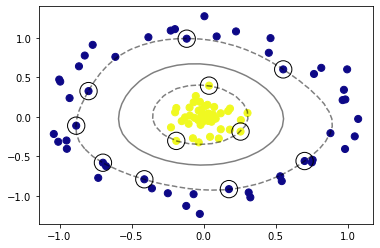

In [14]:
svc = SVC(kernel='rbf', C=1E6)
svc.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma')
frontiere(svc)
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1],s=300, lw=1, facecolors='none');

## 5. Tuning the SVM: Softening Margins

Jusqu'ici on a regardé des données très propres pour lesquelles une frontière "parfaite" existait. Place à un petit peu de bazar maintenant !

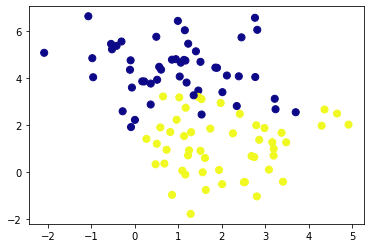

In [15]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma');

Pour gérer ce cas, l'algorithme a un paramètre C qui permet d'assouplir la marge. Cela permet d'autoriser certains points à être dans la marge, si cela permet un meilleur fit. C correspond à la rigidité de la marge :
- pour C élevé, la marge est rigide et ne laisse pas de points entrer $\Rightarrow$ largeur de la marge plus faible
- pour C faible, la marge est plus souple et certains points peuvent donc être à l'intérieur $\Rightarrow$ largeur de la marge plus large

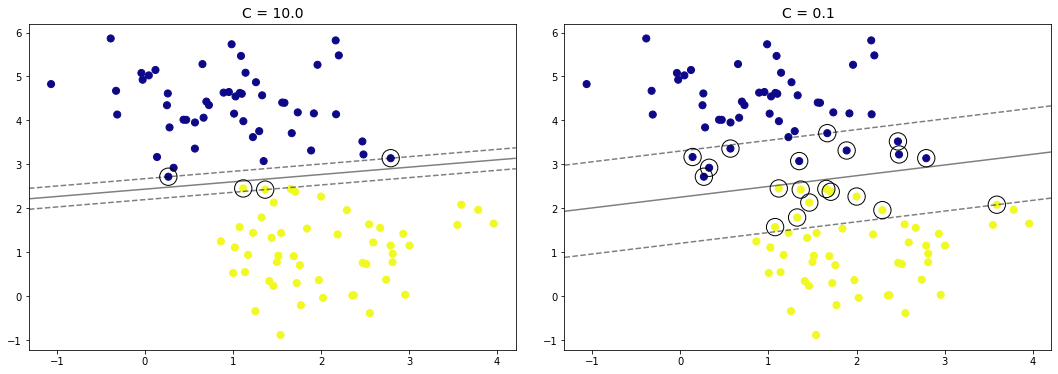

In [16]:
X, y = make_blobs(n_samples=100, centers=2,random_state=0, cluster_std=0.8)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for ax, C in zip(axes, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma')
    frontiere(model, ax)
    ax.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    ax.set_title('C = {0:.1f}'.format(C), size=14)

La meilleure valeur de C dépend des données et doit être choisie par validation croisée.

## 6. Un exemple : la reconnaissance faciale

On va faire se faire un petite application avec des SVM à la reconnaissance faciale. On va utiliser les données Labeled Faces du dataset Wild qui contient un peu plus de 1000 de photos de différentes personnalités publiques.

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

Voyons ce qu'il y a dedans.

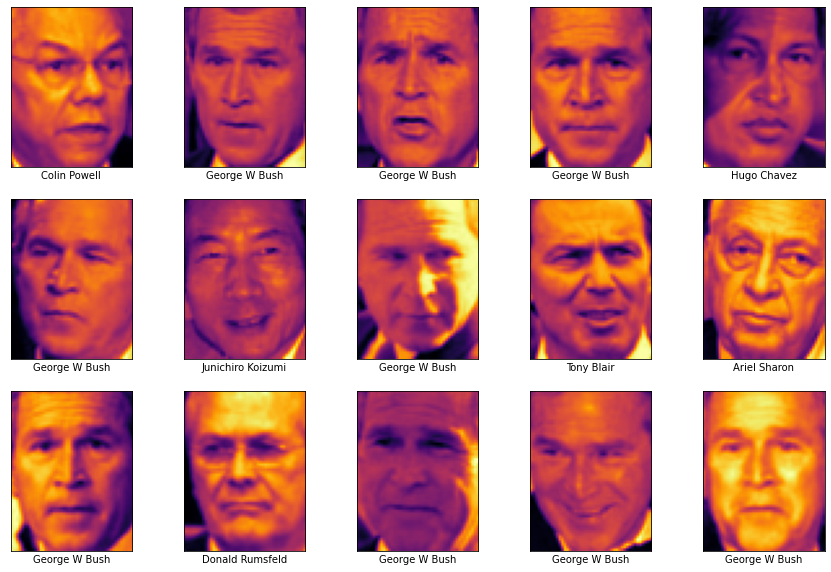

In [18]:
fig, axes = plt.subplots(3, 5, figsize=(15,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(faces.images[i], cmap="inferno")
    ax.set(xticks=[], yticks=[],xlabel=faces.target_names[faces.target[i]])

Bon. On aurait préféré l'équipe de France 98 enfin c'est comme ça. Regardons plus précisement ce que contient notre dataset.

In [19]:
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Il y a donc précisément 1348 images de tailles 62x47 soit quasi 3000 pixels. On pourrait simplement utiliser chaque pixel comme un feature mais généralement on utilise une méthode pour extraire les pixels les plus "important". On va faire un Analyse en Composantes Principales (ACP en français, PCA en anglais) pour extraire les 150 composants fondamentaux et s'en servir comme features pour notre modèle SVC. On va faire une pipeline pour coller ensemble le preprocessor PCA et le classifieur SVC.

In [20]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1011, 2914), (337, 2914), (1011,), (337,))

On va ensuite faire une validation croisée avec GridSearchCV pour voir les différentes combinaisons d'hyperparamètres et déterminer ceux qui sont optimaux. On va jouer ici sur C (qui contrôle la rigidité de la marge) et gamma (dont on a pas encore parlé mais qui contrôle la taille du kernel rbf).

In [22]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'pca__n_components': [50,10,150,200],
    'svc__C': [1, 5, 10, 50], # model__parametre
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]
}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)
print(grid.best_params_)

CPU times: user 8min 56s, sys: 4min 57s, total: 13min 54s
Wall time: 1min 57s
{'pca__n_components': 150, 'svc__C': 10, 'svc__gamma': 0.001}


Les valeurs optimales se trouvent au milieu de notre grille. Si elles avaient été aux extrémités, il aurait fallu étendre un peu la grille.

Maintenant on va pouvoir prédire nos images test.

In [23]:
model = grid.best_estimator_
y_pred = model.predict(X_test)
model

Pipeline(steps=[('pca',
                 PCA(n_components=150, random_state=42, svd_solver='randomized',
                     whiten=True)),
                ('svc', SVC(C=10, class_weight='balanced', gamma=0.001))])

On affiche quelques images test et leur valeur prédite.

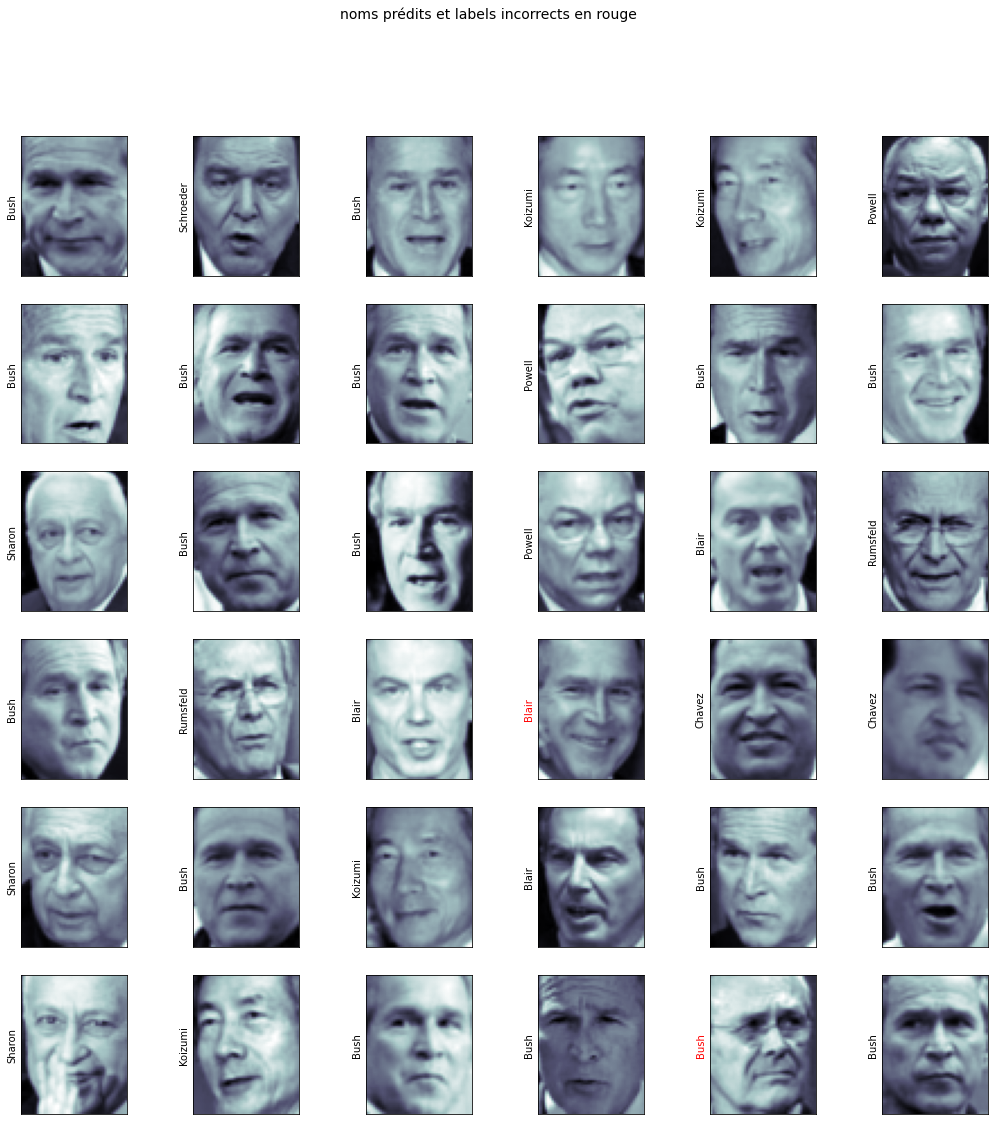

In [30]:
fig, axes = plt.subplots(6, 6, figsize=(18,18))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(62, 47), cmap='bone')
    ax.set(xticks=[], yticks=[])
    ax.set_ylabel(faces.target_names[y_pred[i]].split()[-1], color='black' if y_pred[i] == y_test[i] else 'red')
fig.suptitle('noms prédits et labels incorrects en rouge', size=14);

On voit les images mal classées mais il y en a peu. Blair à la place de Bush (en même temps y a de quoi les confondre...). On peut regarder le classification_report de sklearn pour voir un peu mieux ce qu'il se passe et la matrice de confusion.

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



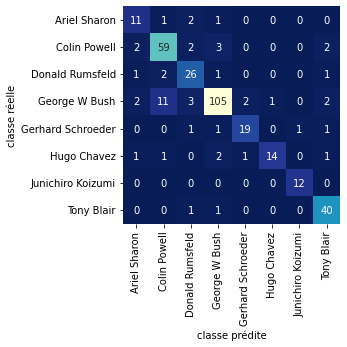

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names,
            cmap='YlGnBu_r'
           )
plt.xlabel('classe prédite')
plt.ylabel('classe réelle');

Cela permet de mieux voir quel label risquent d'être confondus par l'estimateur.

Pour ce qui est de la reconnaissance faciale dans la "vraie vie", où on a pas des grilles de photos bien taillée, la seule différence est sur la partie sélection de variables : il faudrait utiliser des méthodes plus sophistiquées pour déterminer où se situent les visages etc...mais c'est tout à fait accessible !

## En résumé

On a un peu vu ce qu'était les principes des SVM qui sont un méthode de classification puissantes pour plusieurs raisons:
- dépendance à quelques vecteurs supports seulement donc modèle **compact** et nécessitant **peu de mémoire**
- **prédiction très rapide** une fois que le modèle est entraîné
- fonctionne bien pour des problèmes d'assez **grandes dimensions**, y compris ceux qui auraient plus de features que d'observations (cas assez difficile à gérer en général)
- l'utilisation des kernel en fait une méthode **adaptable**

Quelques inconvénients cela dit évidemment :
- Le temps d'entraînement est au minimum **quadratique**, c'est-à-dire **long** pour des grands training sets
- Les résultats sont fortement dépendant d'un **bon choix du paramètre C** (qui doit donc être affiné par validation croisée ce qui, encore une fois peut être très coûteux en temps...)
- Les résultats ne sont **pas probabilistes** (pas de probabilité associée à chaque élément donc). On peut estimer des probabilités par validation croisée (voir les paramètres de sklearn.svm.SVC) mais de nouveau, problème de temps d'exécution